IMPORT STANDARD LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
from math import *
import cv2

READ DATASET AND VIEW ITS SHAPE

In [2]:
data=pd.read_csv("age_gender.csv")

In [3]:
data.shape

(23705, 5)

In [4]:
data.drop("img_name",axis=1,inplace=True)

APPLY GAUSSIAN FILTER TO REDUCE NOISE AND VISUALIZE THE IMAGES

In [5]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [6]:
def reduce_noise(img):

    img = np.reshape(img, (48,48))
    
    kernel = cv2.getGaussianKernel(5,1)

    noiseless_img = cv2.filter2D(img,-1,kernel)

    return np.reshape(noiseless_img, -1)


data['pixels'] = data['pixels'].apply(reduce_noise)

In [7]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x, dtype="float32"))/255

In [8]:
def plot_image(im):
  num = len(im)
  rows = ceil(num/5)
  cols = 5

  fig, axes = plt.subplots(rows, cols, figsize=(10*cols, 10*rows))
  # colour_maps=['viridis','gray','inferno','magma','plasma','cividis']
  for image, i in zip(im, [i for i in range(num*2)]):
    images_of_dataset = np.asarray(data.loc[image, "pixels"]).reshape(48, 48)
    image_info = "Age of person:"+str(data.loc[image, "age"]) +\
        "Ethnicity:"+str(data.loc[image, "ethnicity"]) +\
        "Gender:"+str(data.loc[image, "gender"])
    ax = axes[i//cols, i % cols]
    ax.imshow(images_of_dataset, cmap='gray', vmin=0, vmax=1)
    ax.set_title(image_info, fontsize=26)
  plt.tight_layout()
  plt.show()


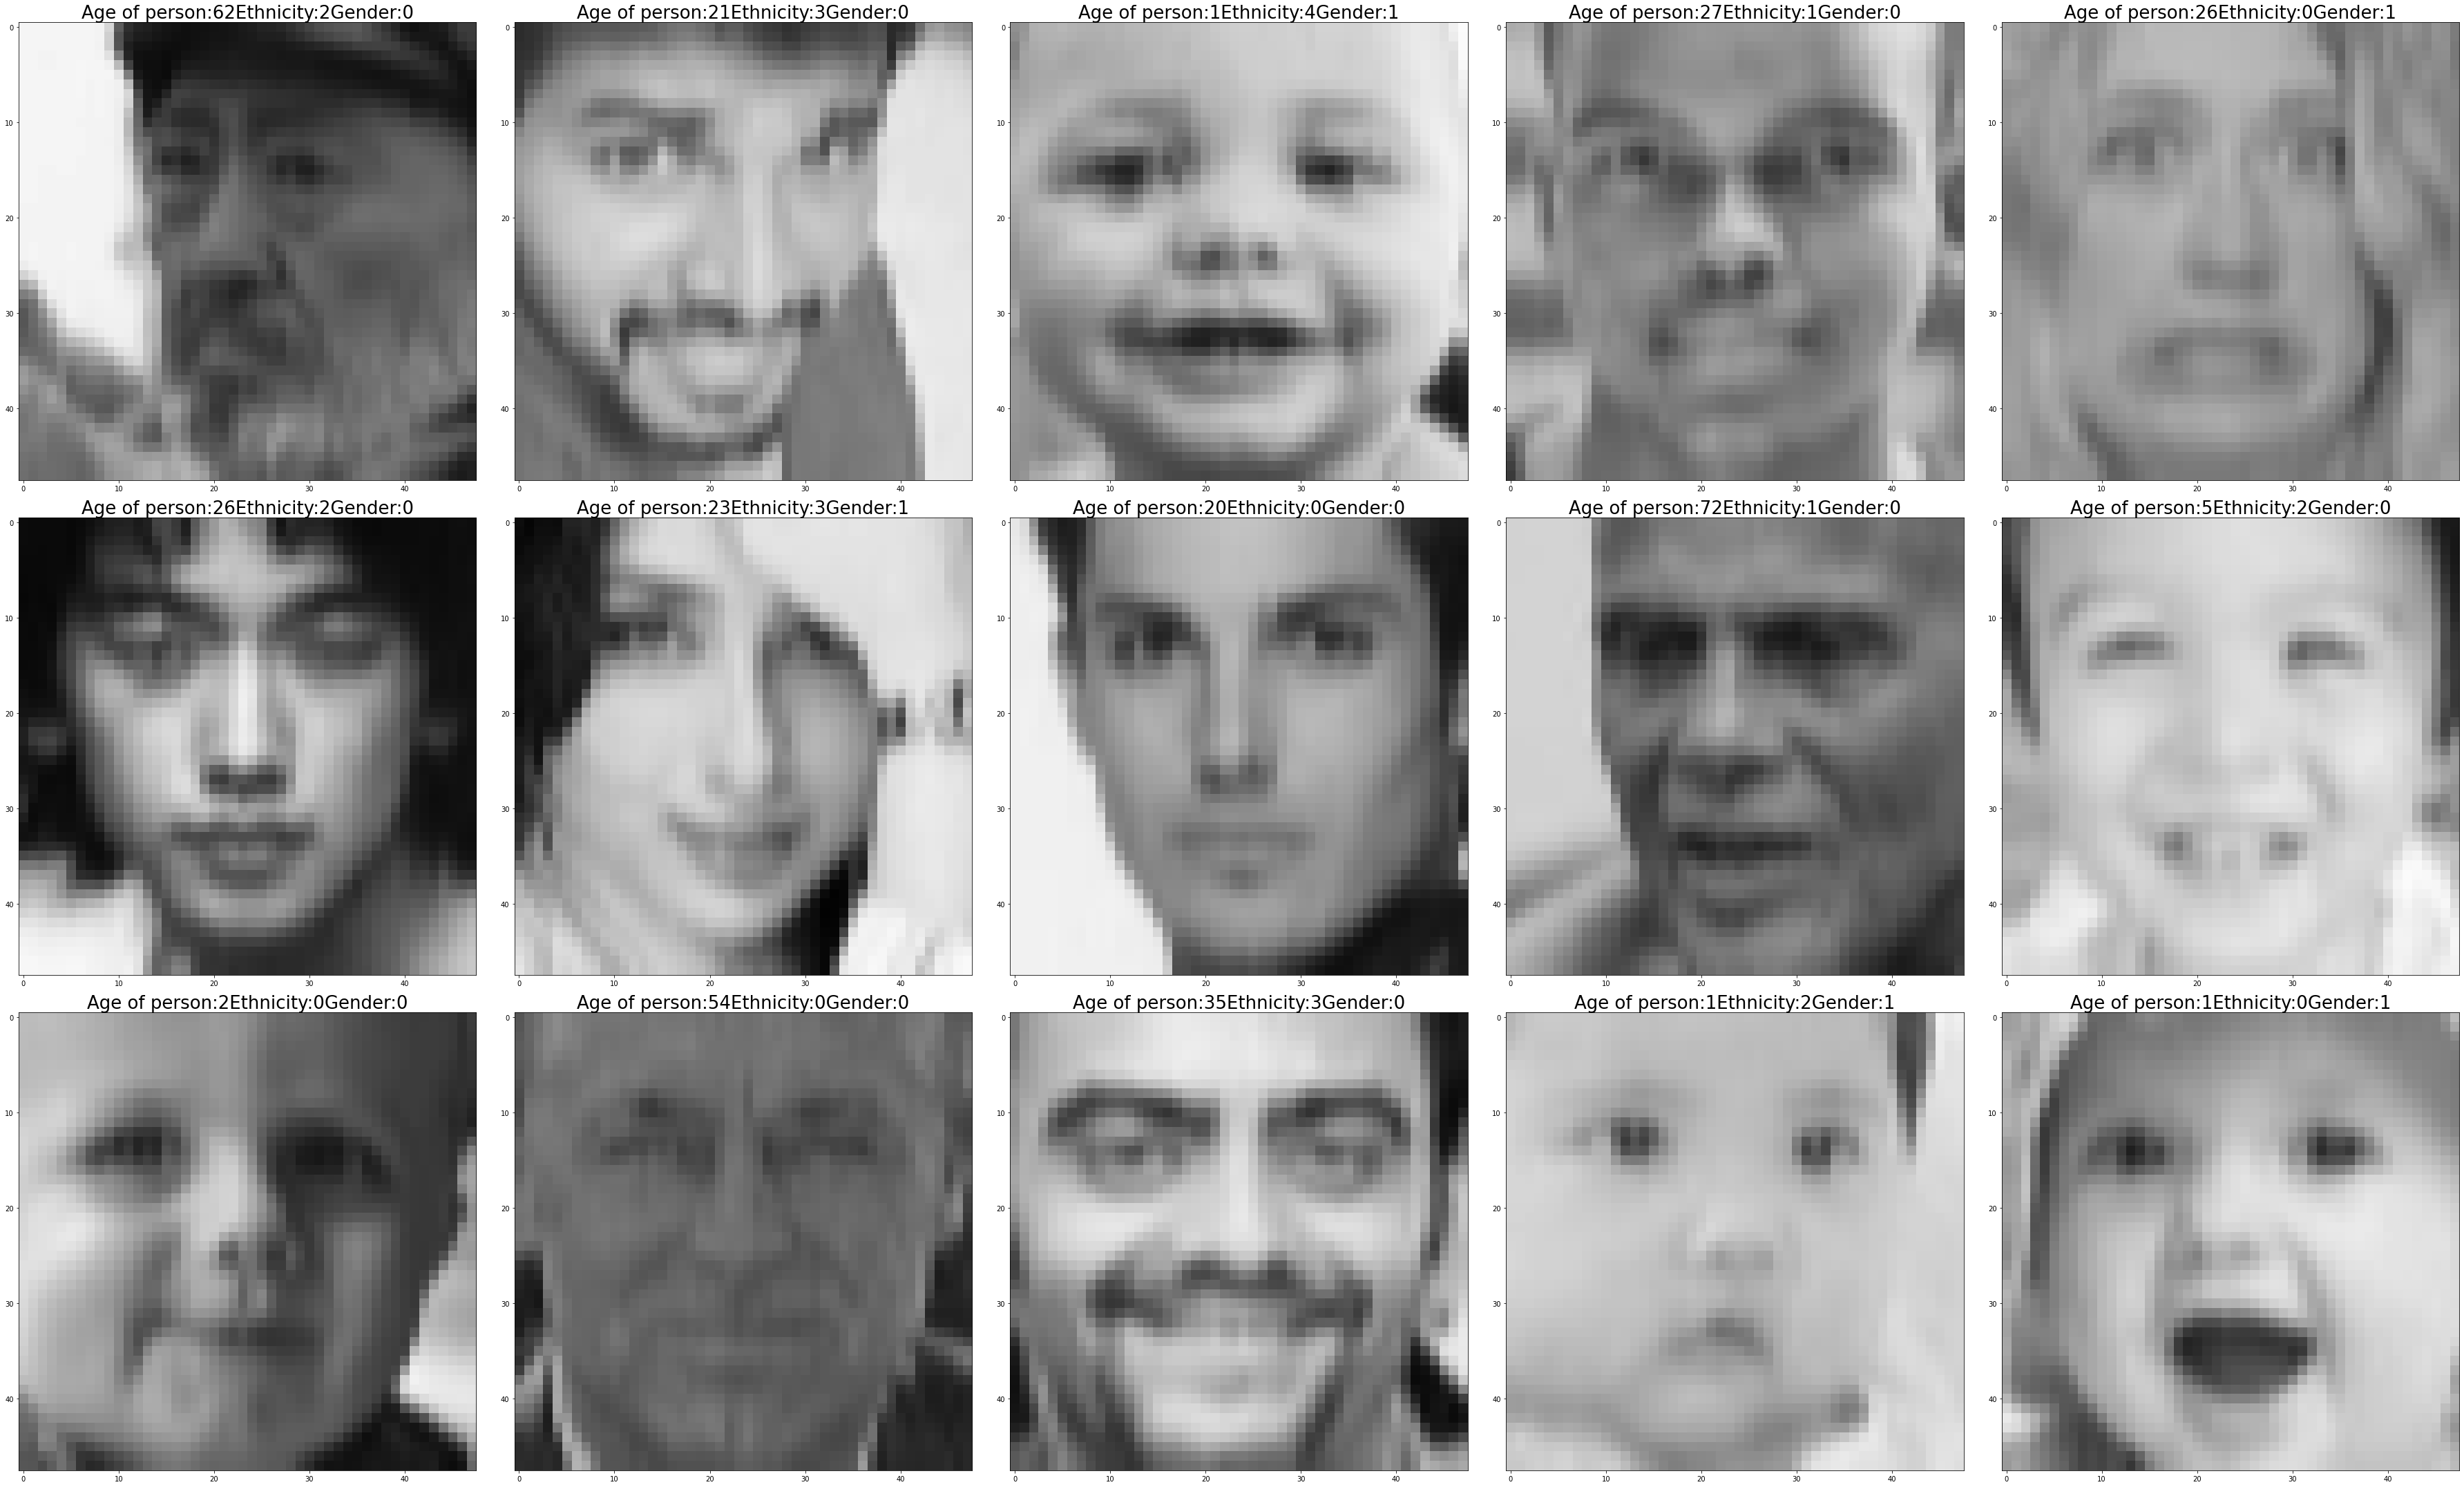

In [9]:
random.seed(42)
plot_image([random.randint(0,len(data)) for _ in range(15)])

<AxesSubplot:xlabel='gender', ylabel='count'>

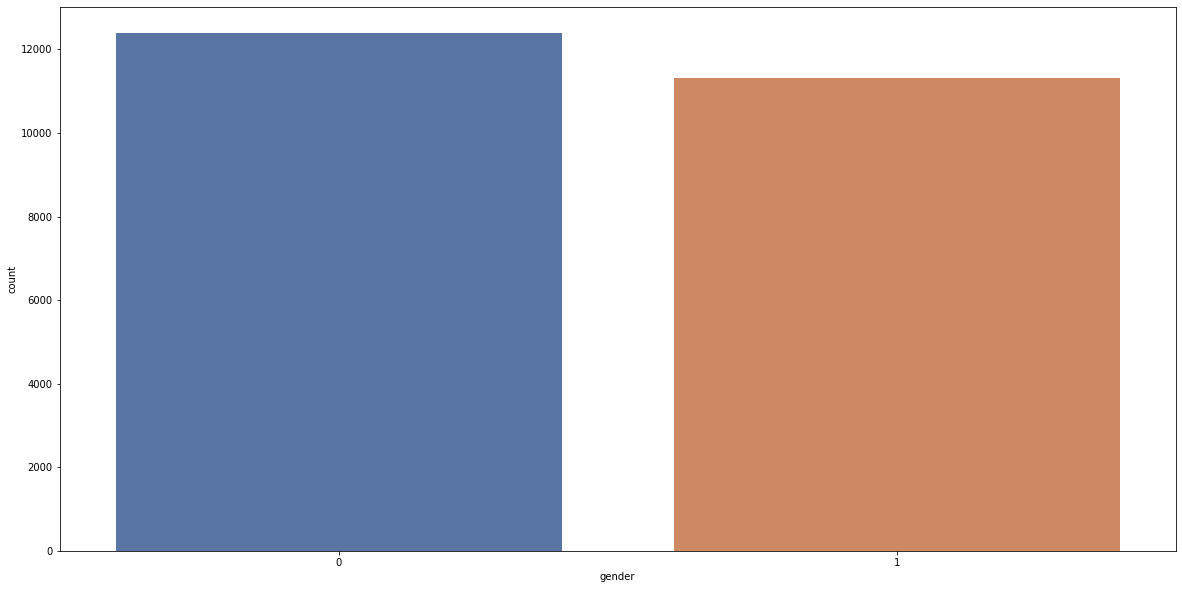

In [10]:
plt.figure(figsize=(20,10))
sns.set_palette("deep")
sns.countplot(x='gender',data=data)

<AxesSubplot:xlabel='gender', ylabel='count'>

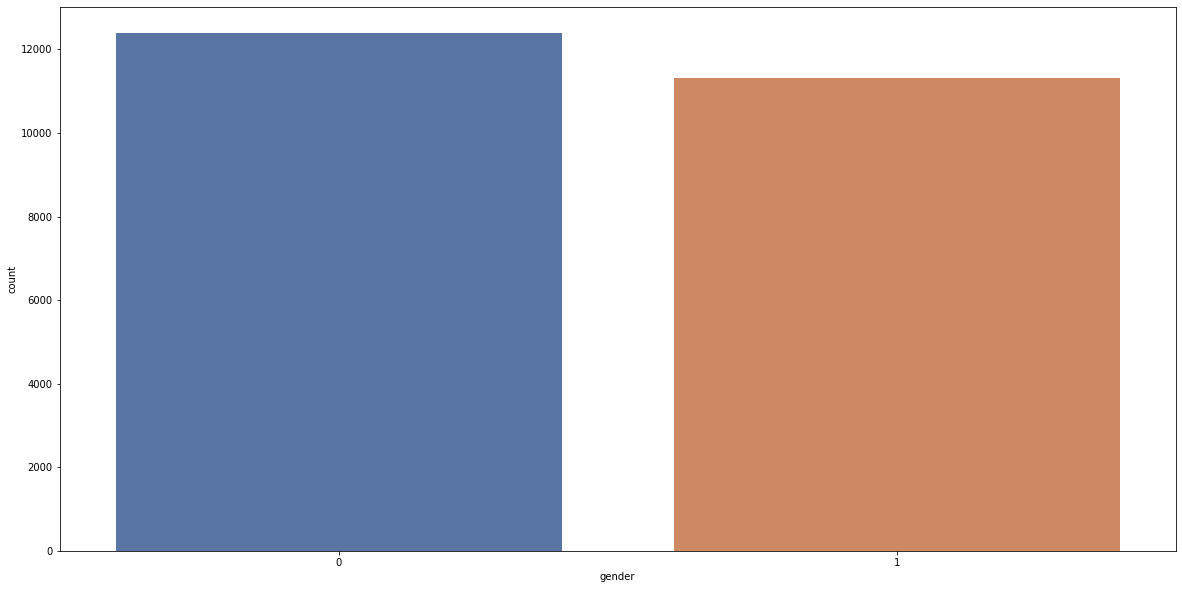

In [11]:
plt.figure(figsize=(20,10))
sns.set_palette("deep")
sns.countplot(x='gender',data=data)

<AxesSubplot:xlabel='age', ylabel='Count'>

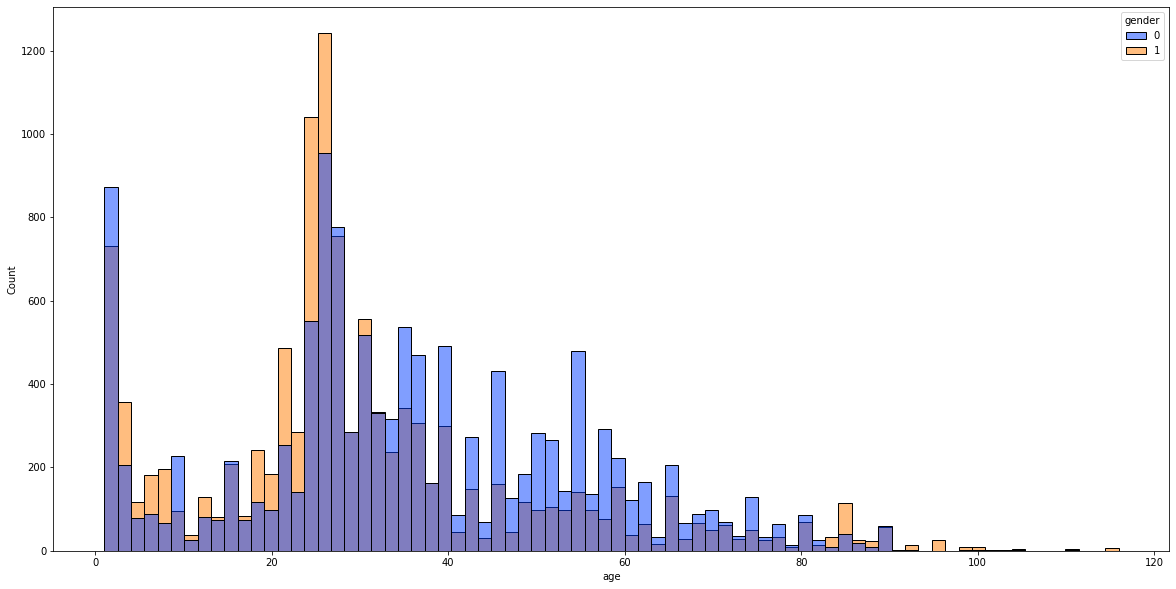

In [12]:
plt.figure(figsize=(20,10))
sns.set_palette("bright")
sns.histplot(x='age',data=data,hue='gender')

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

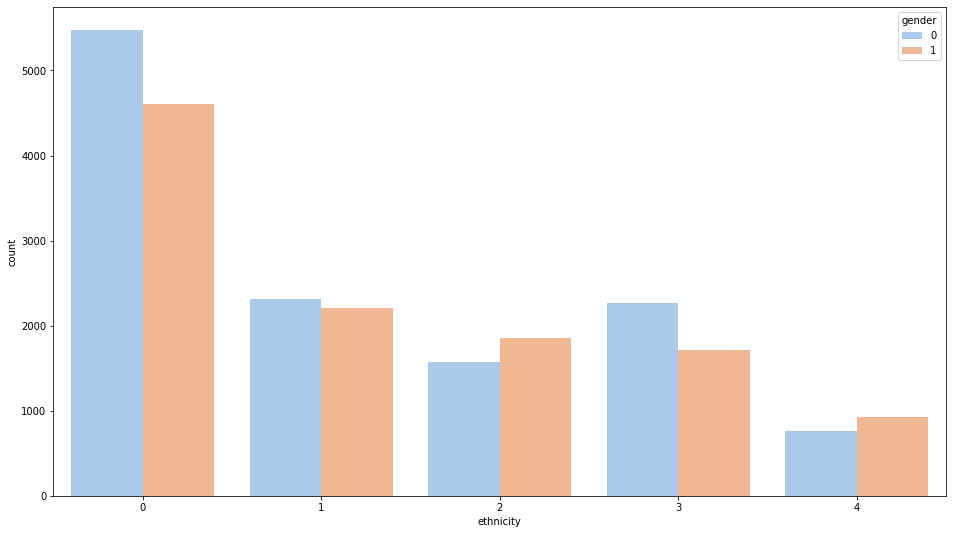

In [14]:
plt.figure(figsize=(16,9))
sns.set_palette("pastel")
sns.countplot(x ='ethnicity',hue="gender", data = data) 

In [78]:
x=data['pixels']

In [79]:
x_t=[]
for i in range(x.shape[0]):
  x_t.append(x[i].reshape(48,48,1))
x=np.array(x_t)

In [80]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train_gender,y_test_gender,y_train_ethnicity,y_test_ethnicity,y_train_age,y_test_age=train_test_split(x,pd.get_dummies(data['gender']).values,pd.get_dummies(data['ethnicity']).values,data['age'].values,test_size=0.1, random_state=1234)

x_val, x_test, y_val_gender, y_test_gender, y_val_ethnicity, y_test_ethnicity, y_val_age, y_test_age = train_test_split(
    x_test, y_test_gender, y_test_ethnicity, y_test_age,test_size=0.5, random_state=1234)

In [81]:
import tensorflow as tf
from tensorflow import keras
from keras import layers,Input,Model
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,LeakyReLU,GlobalAvgPool2D
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy,binary_crossentropy,categorical_crossentropy
from keras.optimizers import Adam,SGD,RMSprop,Adagrad
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


In [82]:
def CNN_model():
    inputs = Input(shape=(48, 48, 1))
    x = inputs
    for i in range(3):
        filters = 32 + i*32
        for _ in range(2):
            x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.01)(x)
        if i < 2:
            x = MaxPool2D()(x)
    x = GlobalAvgPool2D()(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=512, activation='relu')(x)
    out_gender = Dense(2, activation='sigmoid', name='gender_out')(x)
    out_ethnicity = Dense(5, activation='softmax', name='ethnicity_out')(x)
    out_age = Dense(1, name='age_out')(x)
    model = Model(inputs=inputs, outputs=[
                           out_gender, out_ethnicity, out_age])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss={'gender_out': 'binary_crossentropy',
              'ethnicity_out': 'categorical_crossentropy',
              'age_out': 'mse'},
        metrics={'gender_out': 'accuracy',
                 'ethnicity_out': 'accuracy',
                 'age_out': 'mae'})
    return model


In [83]:
cnn=CNN_model()
cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 48, 48, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 48, 48, 32)  128         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 48, 48, 32)   0           ['batch_normalization_6[0][

In [85]:
early_stopping=EarlyStopping(
  monitor='val_loss',
  patience=8,
  verbose=1,
  restore_best_weights=True
  
)

In [86]:
epochs=35
batch_size=16
history_list=[]
history = cnn.fit(x_train, {'gender_out': y_train_gender, 'ethnicity_out': y_train_ethnicity, 'age_out': y_train_age},
                         batch_size=batch_size,
                         epochs=epochs, validation_data=(
                             x_val, [y_val_gender, y_val_ethnicity, y_val_age]),
                         steps_per_epoch=(x_train.shape[0] // batch_size),
                         callbacks=[early_stopping]
                         )

history_list.append(history)


Epoch 1/35
1333/1333 [==============================] - 468s 341ms/step - loss: 304.3659 - gender_out_loss: 0.7041 - ethnicity_out_loss: 1.4632 - age_out_loss: 302.1983 - gender_out_accuracy: 0.5380 - ethnicity_out_accuracy: 0.4047 - age_out_mae: 13.0566 - val_loss: 244.1957 - val_gender_out_loss: 0.6700 - val_ethnicity_out_loss: 1.3450 - val_age_out_loss: 242.1806 - val_gender_out_accuracy: 0.5662 - val_ethnicity_out_accuracy: 0.4616 - val_age_out_mae: 12.1491
Epoch 2/35
1333/1333 [==============================] - 473s 355ms/step - loss: 184.0620 - gender_out_loss: 0.6914 - ethnicity_out_loss: 1.3927 - age_out_loss: 181.9780 - gender_out_accuracy: 0.5596 - ethnicity_out_accuracy: 0.4501 - age_out_mae: 10.2730 - val_loss: 229.1896 - val_gender_out_loss: 0.6677 - val_ethnicity_out_loss: 1.3164 - val_age_out_loss: 227.2053 - val_gender_out_accuracy: 0.6228 - val_ethnicity_out_accuracy: 0.4700 - val_age_out_mae: 12.6074
Epoch 3/35
1333/1333 [==============================] - 375s 281ms/s

In [87]:
history_list

In [88]:
pred=cnn.predict(x_test)


38/38 [==============================] - 14s 185ms/step


In [89]:
test_loss,test_gender_loss, test_ethnicity_loss, test_age_loss, test_gender_acc,test_ethnicity_acc,test_age_mae = cnn.evaluate(x_test, [y_test_gender, y_test_ethnicity, y_test_age], verbose=0)

In [90]:
print(f"Gender loss:{test_gender_loss}")
print(f"Ethnicity_loss:{test_ethnicity_loss}")
print(f"Age_loss:{test_age_loss}")
print(f"Gender accuracy:{test_gender_acc}")
print(f"Ethnicity accuracy:{test_ethnicity_acc}")
print(f"Age Error:{test_age_mae}")

Gender loss:0.6511666774749756
Ethnicity_loss:1.243277668952942
Age_loss:91.92339324951172
Gender accuracy:0.6374367475509644
Ethnicity accuracy:0.5210792422294617
Age Error:6.926730632781982


In [91]:
from sklearn.metrics import classification_report,confusion_matrix


In [92]:
y_pred_gender = np.argmax(pred[0], axis=1)
y_true_gender = np.argmax(y_test_gender, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_true_gender, y_pred_gender))
print('Classification Report')
target_names = ['Woman', 'Man']
print(classification_report(y_true_gender,
      y_pred_gender, target_names=target_names))


Confusion Matrix
[[432 168]
 [262 324]]
Classification Report
              precision    recall  f1-score   support

       Woman       0.62      0.72      0.67       600
         Man       0.66      0.55      0.60       586

    accuracy                           0.64      1186
   macro avg       0.64      0.64      0.63      1186
weighted avg       0.64      0.64      0.63      1186



In [93]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_ethnicity = np.argmax(pred[1], axis=1)
y_true_ethnicity = np.argmax(y_test_ethnicity, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_true_ethnicity, y_pred_ethnicity))
print('Classification Report')
target_names = ['0', '1', '2', '3', '4']
print(classification_report(y_true_ethnicity,y_pred_ethnicity, target_names=target_names))


Confusion Matrix
[[432  58  23   0   0]
 [ 79 161   2   0   0]
 [ 94  33  25   0   0]
 [137  39  15   0   0]
 [ 62  14  12   0   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       513
           1       0.53      0.67      0.59       242
           2       0.32      0.16      0.22       152
           3       0.00      0.00      0.00       191
           4       0.00      0.00      0.00        88

    accuracy                           0.52      1186
   macro avg       0.28      0.33      0.29      1186
weighted avg       0.38      0.52      0.43      1186



c:\Users\maran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [94]:
def display_errors(errors_index,img_errors,pred_errors,obs_errors):
  n=0
  fig,ax=plt.subplots(2,2,sharex=True,sharey=True,figsize=(20,8))
  for row in range(2):
    for col in range(2):
      error=errors_index[n]
      ax[row, col].imshow((img_errors[error]).reshape((48, 48)), cmap='viridis')
      ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
      n += 1
      

Gender error

In [95]:
y_pred_gender=np.argmax(pred[0],axis=1)
y_true_gender=np.argmax(y_test_gender,axis=1)

In [96]:
errors_gender=(y_pred_gender-y_true_gender!=0)

In [97]:
y_pred_gender_class_errors = y_pred_gender[errors_gender]
y_pred_gender_errors = pred[0][errors_gender]
y_true_errors = y_true_gender[errors_gender]
x_val_errors = x_test[errors_gender]


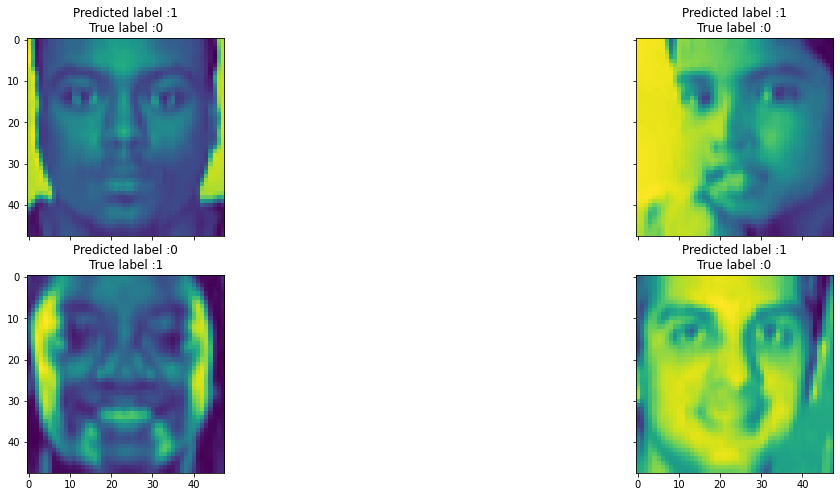

In [98]:
y_pred_gender_errors_prob = np.max(y_pred_gender_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(y_pred_gender_errors, y_true_errors, axis=1))
delta_pred_true_errors = y_pred_gender_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-10:]

display_errors(most_important_errors, x_val_errors, y_pred_gender_class_errors, y_true_errors)

Ethnicity error

In [99]:
y_pred_ethnicity=np.argmax(pred[1],axis=1)
y_true_ethnicity=np.argmax(y_test_ethnicity,axis=1)

In [100]:
errors_ethnicity=(y_pred_ethnicity-y_true_ethnicity!=0)

In [101]:
y_pred_ethnicity_class_errors = y_pred_ethnicity[errors_ethnicity]
y_pred_ethnicity_errors = pred[1][errors_ethnicity]
y_true_ethnicity_errors = y_true_ethnicity[errors_ethnicity]
x_test_ethnicity_errors = x_test[errors_ethnicity]


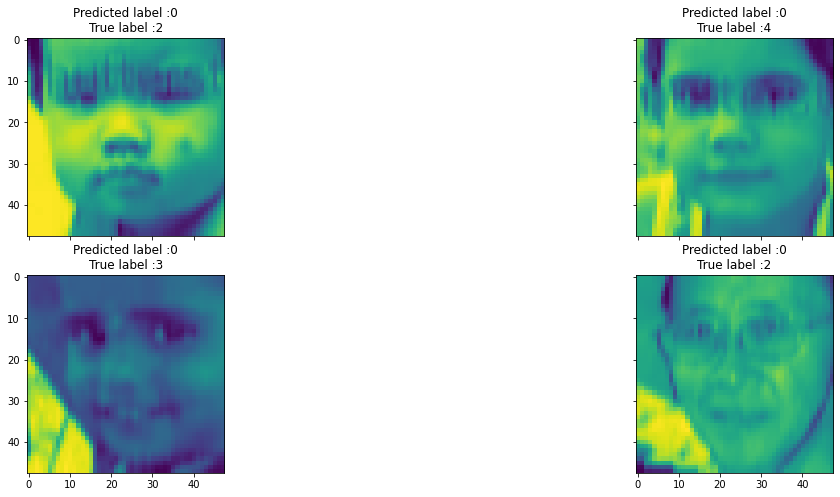

In [102]:
y_pred_ethnicity_errors_prob = np.max(y_pred_ethnicity_errors, axis=1)
true_prob_errors = np.diagonal(np.take(y_pred_ethnicity_errors, y_true_ethnicity_errors, axis=1))
delta_pred_true_ethnicity_errors = y_pred_ethnicity_errors_prob - true_prob_errors
sorted_delta_ethnicity_errors = np.argsort(delta_pred_true_ethnicity_errors)
most_important_errors = sorted_delta_ethnicity_errors[-10:]

display_errors(most_important_errors, x_test_ethnicity_errors, y_pred_ethnicity_class_errors, y_true_ethnicity_errors)


Age Error

In [103]:
y_pred_age=np.around(pred[2]).reshape(pred[2].size)
y_actual_age=y_test_age

In [104]:
age_mse=np.sqrt((y_pred_age-y_actual_age)**2)

In [105]:
def indices(arr,n):
  flat=arr.flatten()
  index=np.argpartition(flat,-n)[-n:]
  index=index[np.argsort(-flat[index])]
  return np.unravel_index(index,arr.shape)

In [106]:
max_mse_age=indices(age_mse,10)[0]

In [107]:
display(max_mse_age,x_test,y_pred_age,y_actual_age)

array([ 544,  680,  542, 1074,  909,  577,  940,  677, 1142,  224],
      dtype=int64)

array([[[[0.53685147],
         [0.46588284],
         [0.43982497],
         ...,
         [0.4060858 ],
         [0.40908602],
         [0.49070263]],

        [[0.5310222 ],
         [0.48034686],
         [0.4414872 ],
         ...,
         [0.40922052],
         [0.41793364],
         [0.49900472]],

        [[0.5128906 ],
         [0.5077381 ],
         [0.45109895],
         ...,
         [0.41674668],
         [0.42895088],
         [0.5119884 ]],

        ...,

        [[0.32769036],
         [0.3123603 ],
         [0.3478285 ],
         ...,
         [0.5194594 ],
         [0.49475873],
         [0.35019097]],

        [[0.33322257],
         [0.31152534],
         [0.34859228],
         ...,
         [0.50929344],
         [0.49316   ],
         [0.3234798 ]],

        [[0.33491227],
         [0.3126253 ],
         [0.34786808],
         ...,
         [0.50558555],
         [0.49253878],
         [0.31068647]]],


       [[[0.6690093 ],
         [0.6739915 ],
         [0.66

array([44., 32.,  3., ...,  4., 36., 28.], dtype=float32)

array([54, 26,  4, ...,  8, 30, 39], dtype=int64)

In [108]:
epochs=26
def plot_loss(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['gender_out_loss'], label='train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_loss'], label='train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['age_out_loss'], label='train_age_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_loss'], label='val_train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_loss'], label='val_train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_loss'], label='val_train_age_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
def plot_acc(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['gender_out_accuracy'], label='train_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_accuracy'], label='train_ethnicity_accuracy')
        
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_accuracy'], label='val_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_accuracy'], label='val_ethnicity_accuracy')


    plt.title(title)
    plt.xlabel('Epoch No')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

def plot_MSE(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['age_out_mae'], label='train_age_mae')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_mae'], label='val_age_mae')

    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Mean Absolute Error')
    plt.legend(loc='upper right')
    plt.show()

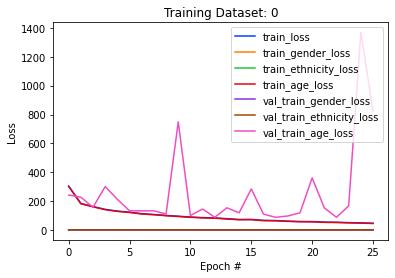

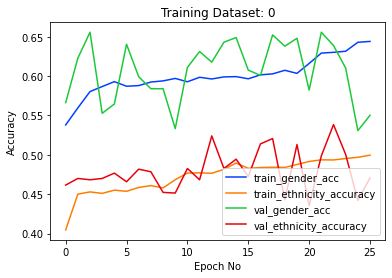

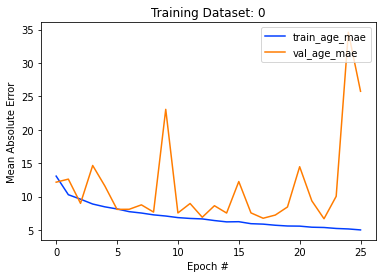

In [110]:
epochs=26
plot_loss(history_list[0], epochs, f'Training Dataset: {0}')
plot_acc(history_list[0], epochs, f'Training Dataset: {0}')
plot_MSE(history_list[0], epochs, f'Training Dataset: {0}')
